In [9]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 
plt.style.use("science.mplstyle")


In [10]:
results_dir = "/global/home/users/rrmastandrea/NF_results/"

n_sig_inj = [1000]

seeds = [0, 1]


## Load in

In [11]:
def get_sic_rejection(idd, seed, n):
    
    loc_dir = f"{results_dir}/nsig_inj{n}_seed1/"
    
    path_to_fpr = f"{loc_dir}/fpr_{idd}_{seed}.npy"
    path_to_tpr = f"{loc_dir}/tpr_{idd}_{seed}.npy"
    fpr = np.load(path_to_fpr)
    tpr = np.load(path_to_tpr)
    rejection = 1.0/fpr
    sic = tpr/np.sqrt(fpr)
    
    
   
    
    return tpr, sic, rejection


x_axis = np.logspace(-8, 0, 400)

rejections_dict = {"cathode":{n:[] for n in n_sig_inj},
                   "sim2real":{n:[] for n in n_sig_inj},
                   "curtains":{n:[] for n in n_sig_inj},
                    "full_sup":{n:[] for n in n_sig_inj}}

sics_dict = {"cathode":{n:[] for n in n_sig_inj},
                   "sim2real":{n:[] for n in n_sig_inj},
                   "curtains":{n:[] for n in n_sig_inj},
                    "full_sup":{n:[] for n in n_sig_inj}}

max_sics_dict = {"cathode":{n:[] for n in n_sig_inj},
                   "sim2real":{n:[] for n in n_sig_inj},
                   "curtains":{n:[] for n in n_sig_inj},
                    "full_sup":{n:[] for n in n_sig_inj}}


keys = ["full_sup", "cathode", "sim2real"]#, "curtains"]


for n in n_sig_inj:
    
    for seed in seeds:
        
        for k in keys:
            
        
            if k == "full_sup":
                tpr, sic, rejection = get_sic_rejection(k, seed, 0)
            else: 
                tpr, sic, rejection = get_sic_rejection(k, seed, n)
                
            
            interp_sic = np.interp(x_axis, tpr, sic)
            interp_rej = np.interp(x_axis, tpr, rejection)
            rejections_dict[k][n].append(interp_rej)
            sics_dict[k][n].append(interp_sic)
            max_sics_dict[k][n].append(np.nanmax(sic[np.isfinite(sic)]))
            



/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


## Take the avg

In [12]:
def get_mean_std(loc_list):
    
    mean = np.nanmedian(loc_list, axis = 0)
    std = np.nanstd(loc_list, axis = 0)
    
    return mean, std

mean_rejections_dict = {"cathode":{n:[] for n in n_sig_inj},
                   "sim2real":{n:[] for n in n_sig_inj},
                   "curtains":{n:[] for n in n_sig_inj},
                    "full_sup":{n:[] for n in n_sig_inj}}

mean_sics_dict = {"cathode":{n:[] for n in n_sig_inj},
                   "sim2real":{n:[] for n in n_sig_inj},
                   "curtains":{n:[] for n in n_sig_inj},
                    "full_sup":{n:[] for n in n_sig_inj}}

mean_max_sics_dict = {"cathode":[[],[]], # mean, stf
                   "sim2real":[[],[]],
                   "curtains":[[],[]],
                     "full_sup":[[],[]]}
   

for n in n_sig_inj:
    
    for k in keys:
        
        mean_rejections_dict[k][n] = get_mean_std(rejections_dict[k][n])
        mean_sics_dict[k][n] = get_mean_std(sics_dict[k][n])
        mean_max_sics_dict[k][0].append(np.median(max_sics_dict[k][n]))
        mean_max_sics_dict[k][1].append(np.std(max_sics_dict[k][n]))
        




for k in keys:
    mean_max_sics_dict[k][0] = np.array(mean_max_sics_dict[k][0])
    mean_max_sics_dict[k][1] = np.array(mean_max_sics_dict[k][1])
    

    

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


# Plot SICs

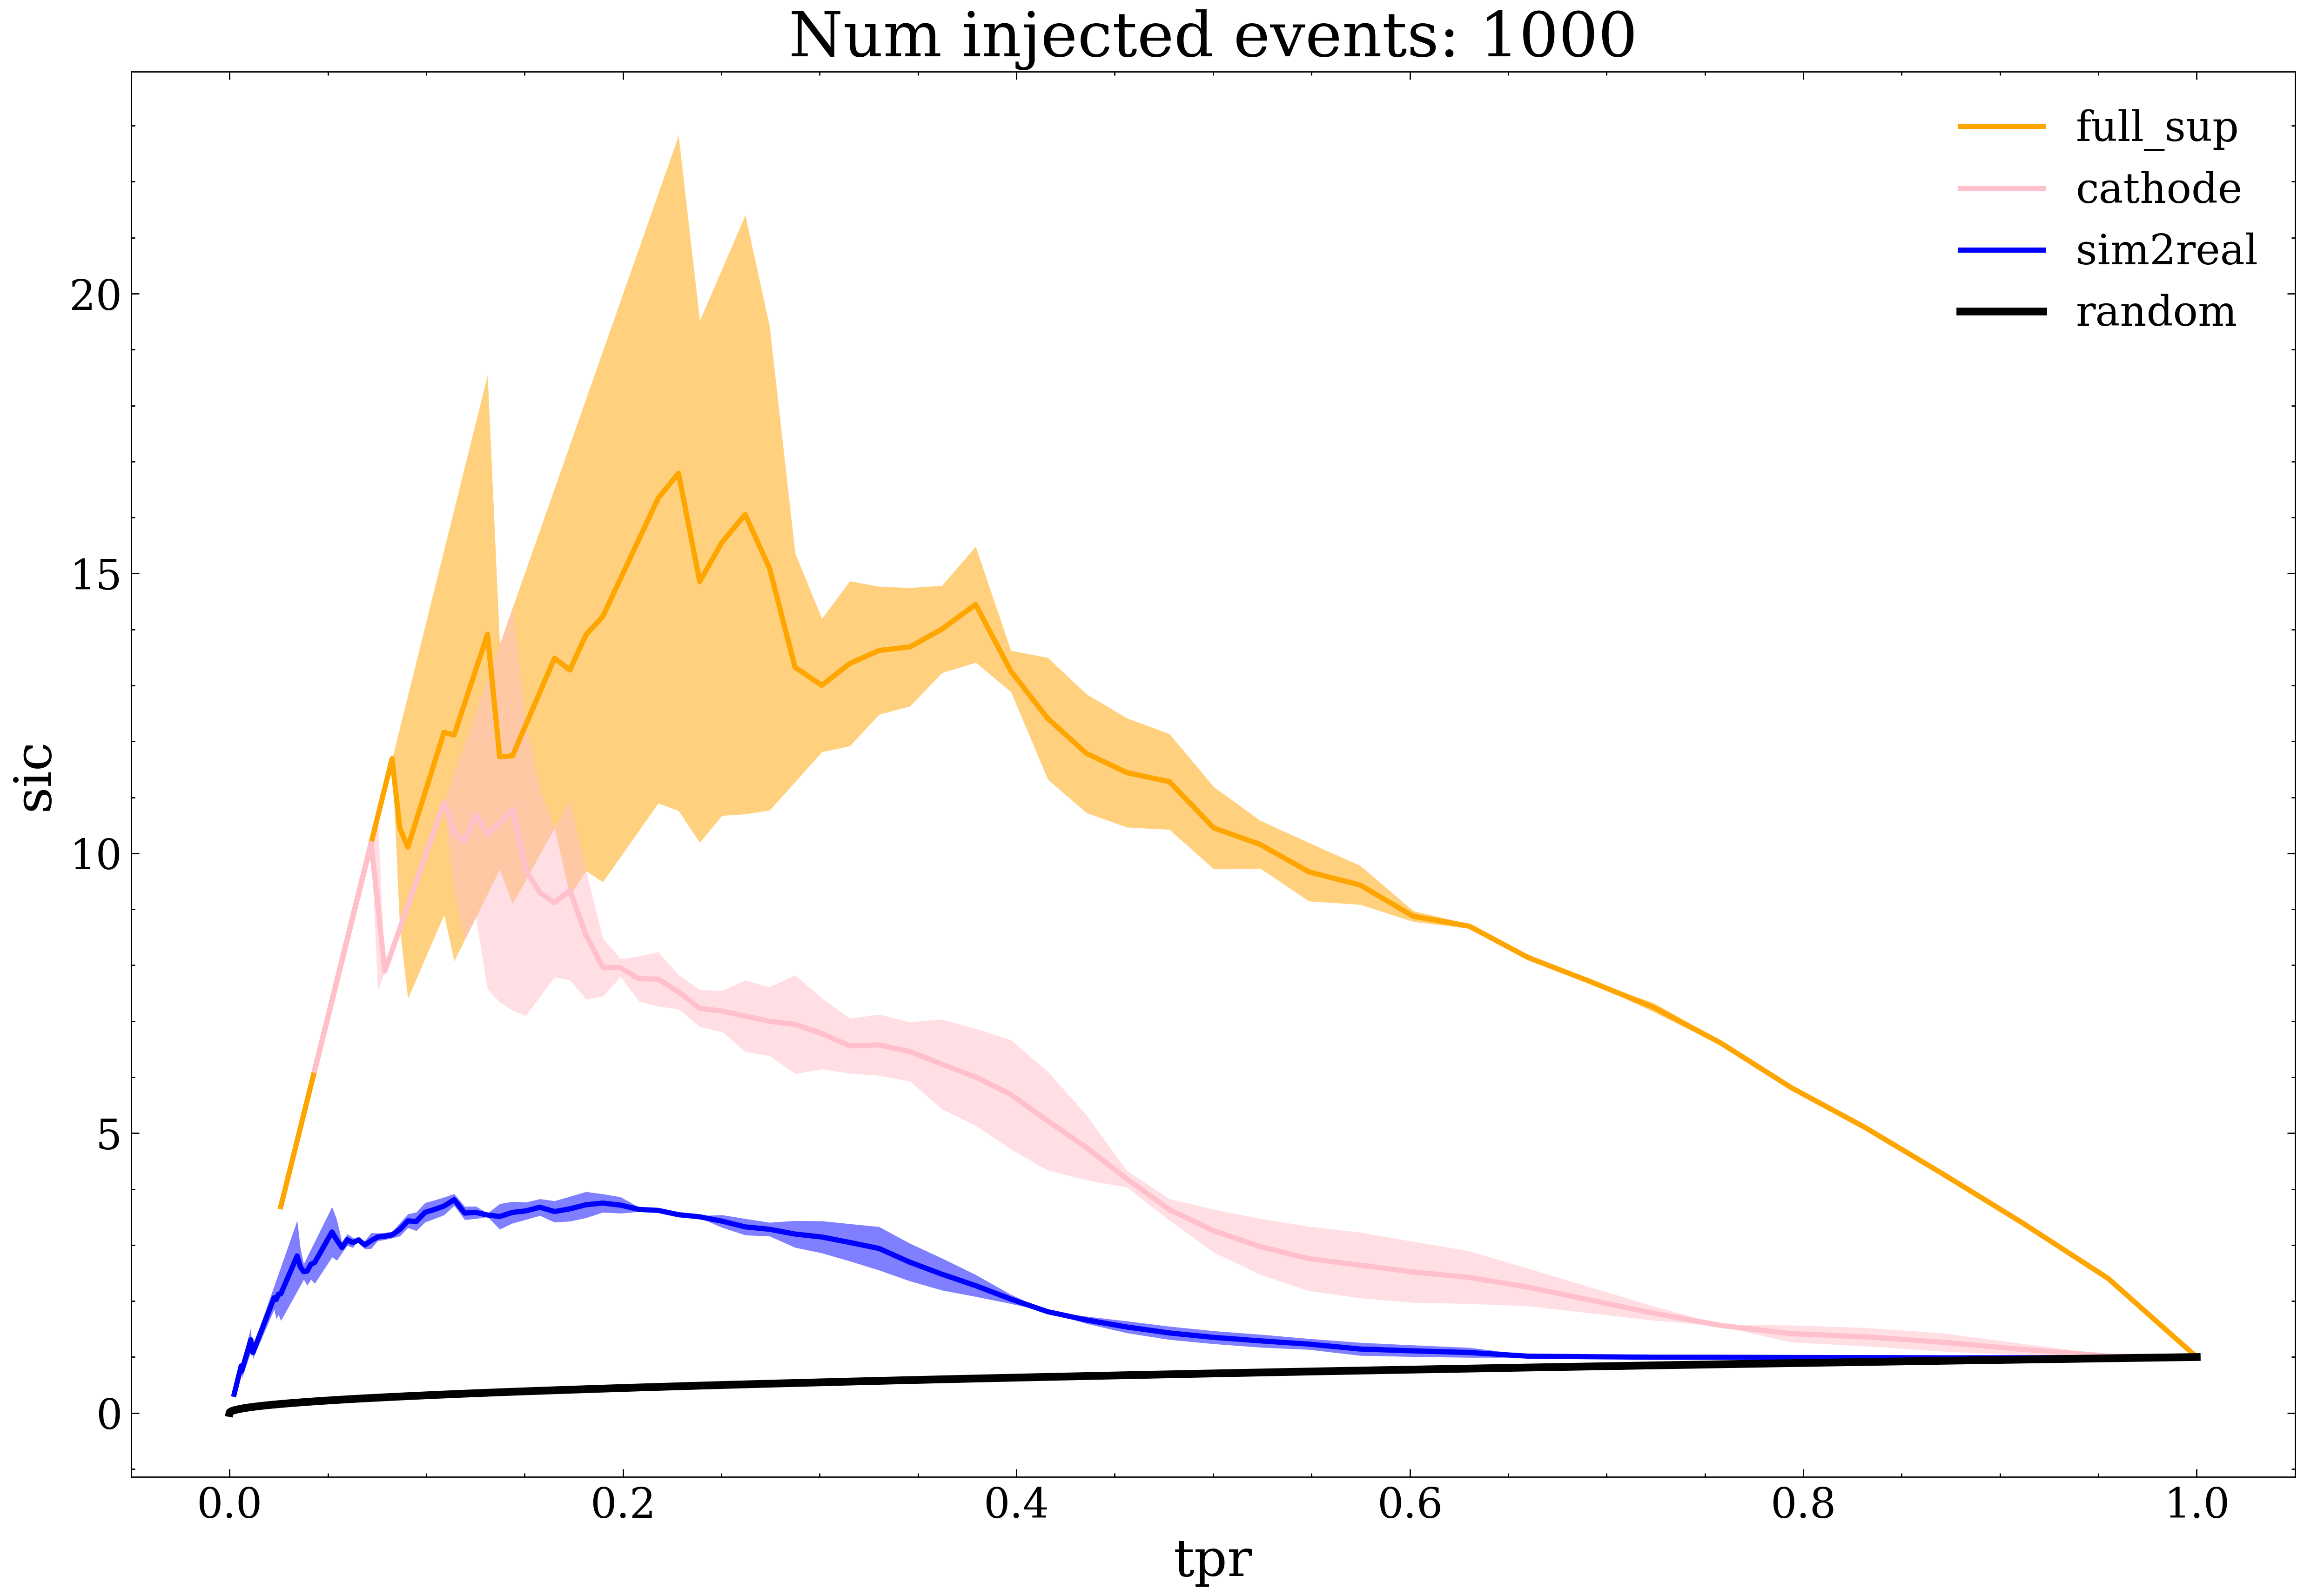

In [13]:
colors_dict = {"cathode":"pink",
                   "sim2real":"blue",
                   "curtains":"green",
                      "full_sup":"orange"}


for n in n_sig_inj:

    plt.figure(figsize = (15, 10))

    for k in keys:
        plt.plot(x_axis, mean_sics_dict[k][n][0], label = k, color = colors_dict[k], linewidth = 2)

        plt.fill_between(x_axis, mean_sics_dict[k][n][0] - mean_sics_dict[k][n][1],
                         mean_sics_dict[k][n][0] + mean_sics_dict[k][n][1],
                         alpha = 0.5, color = colors_dict[k], linewidth = 0)
  

    plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "random", color = "black", linewidth = 3)

    plt.legend()
    plt.xlabel("tpr")
    plt.ylabel("sic")
    plt.title(f"Num injected events: {n}")
    plt.show()

# plot rej

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


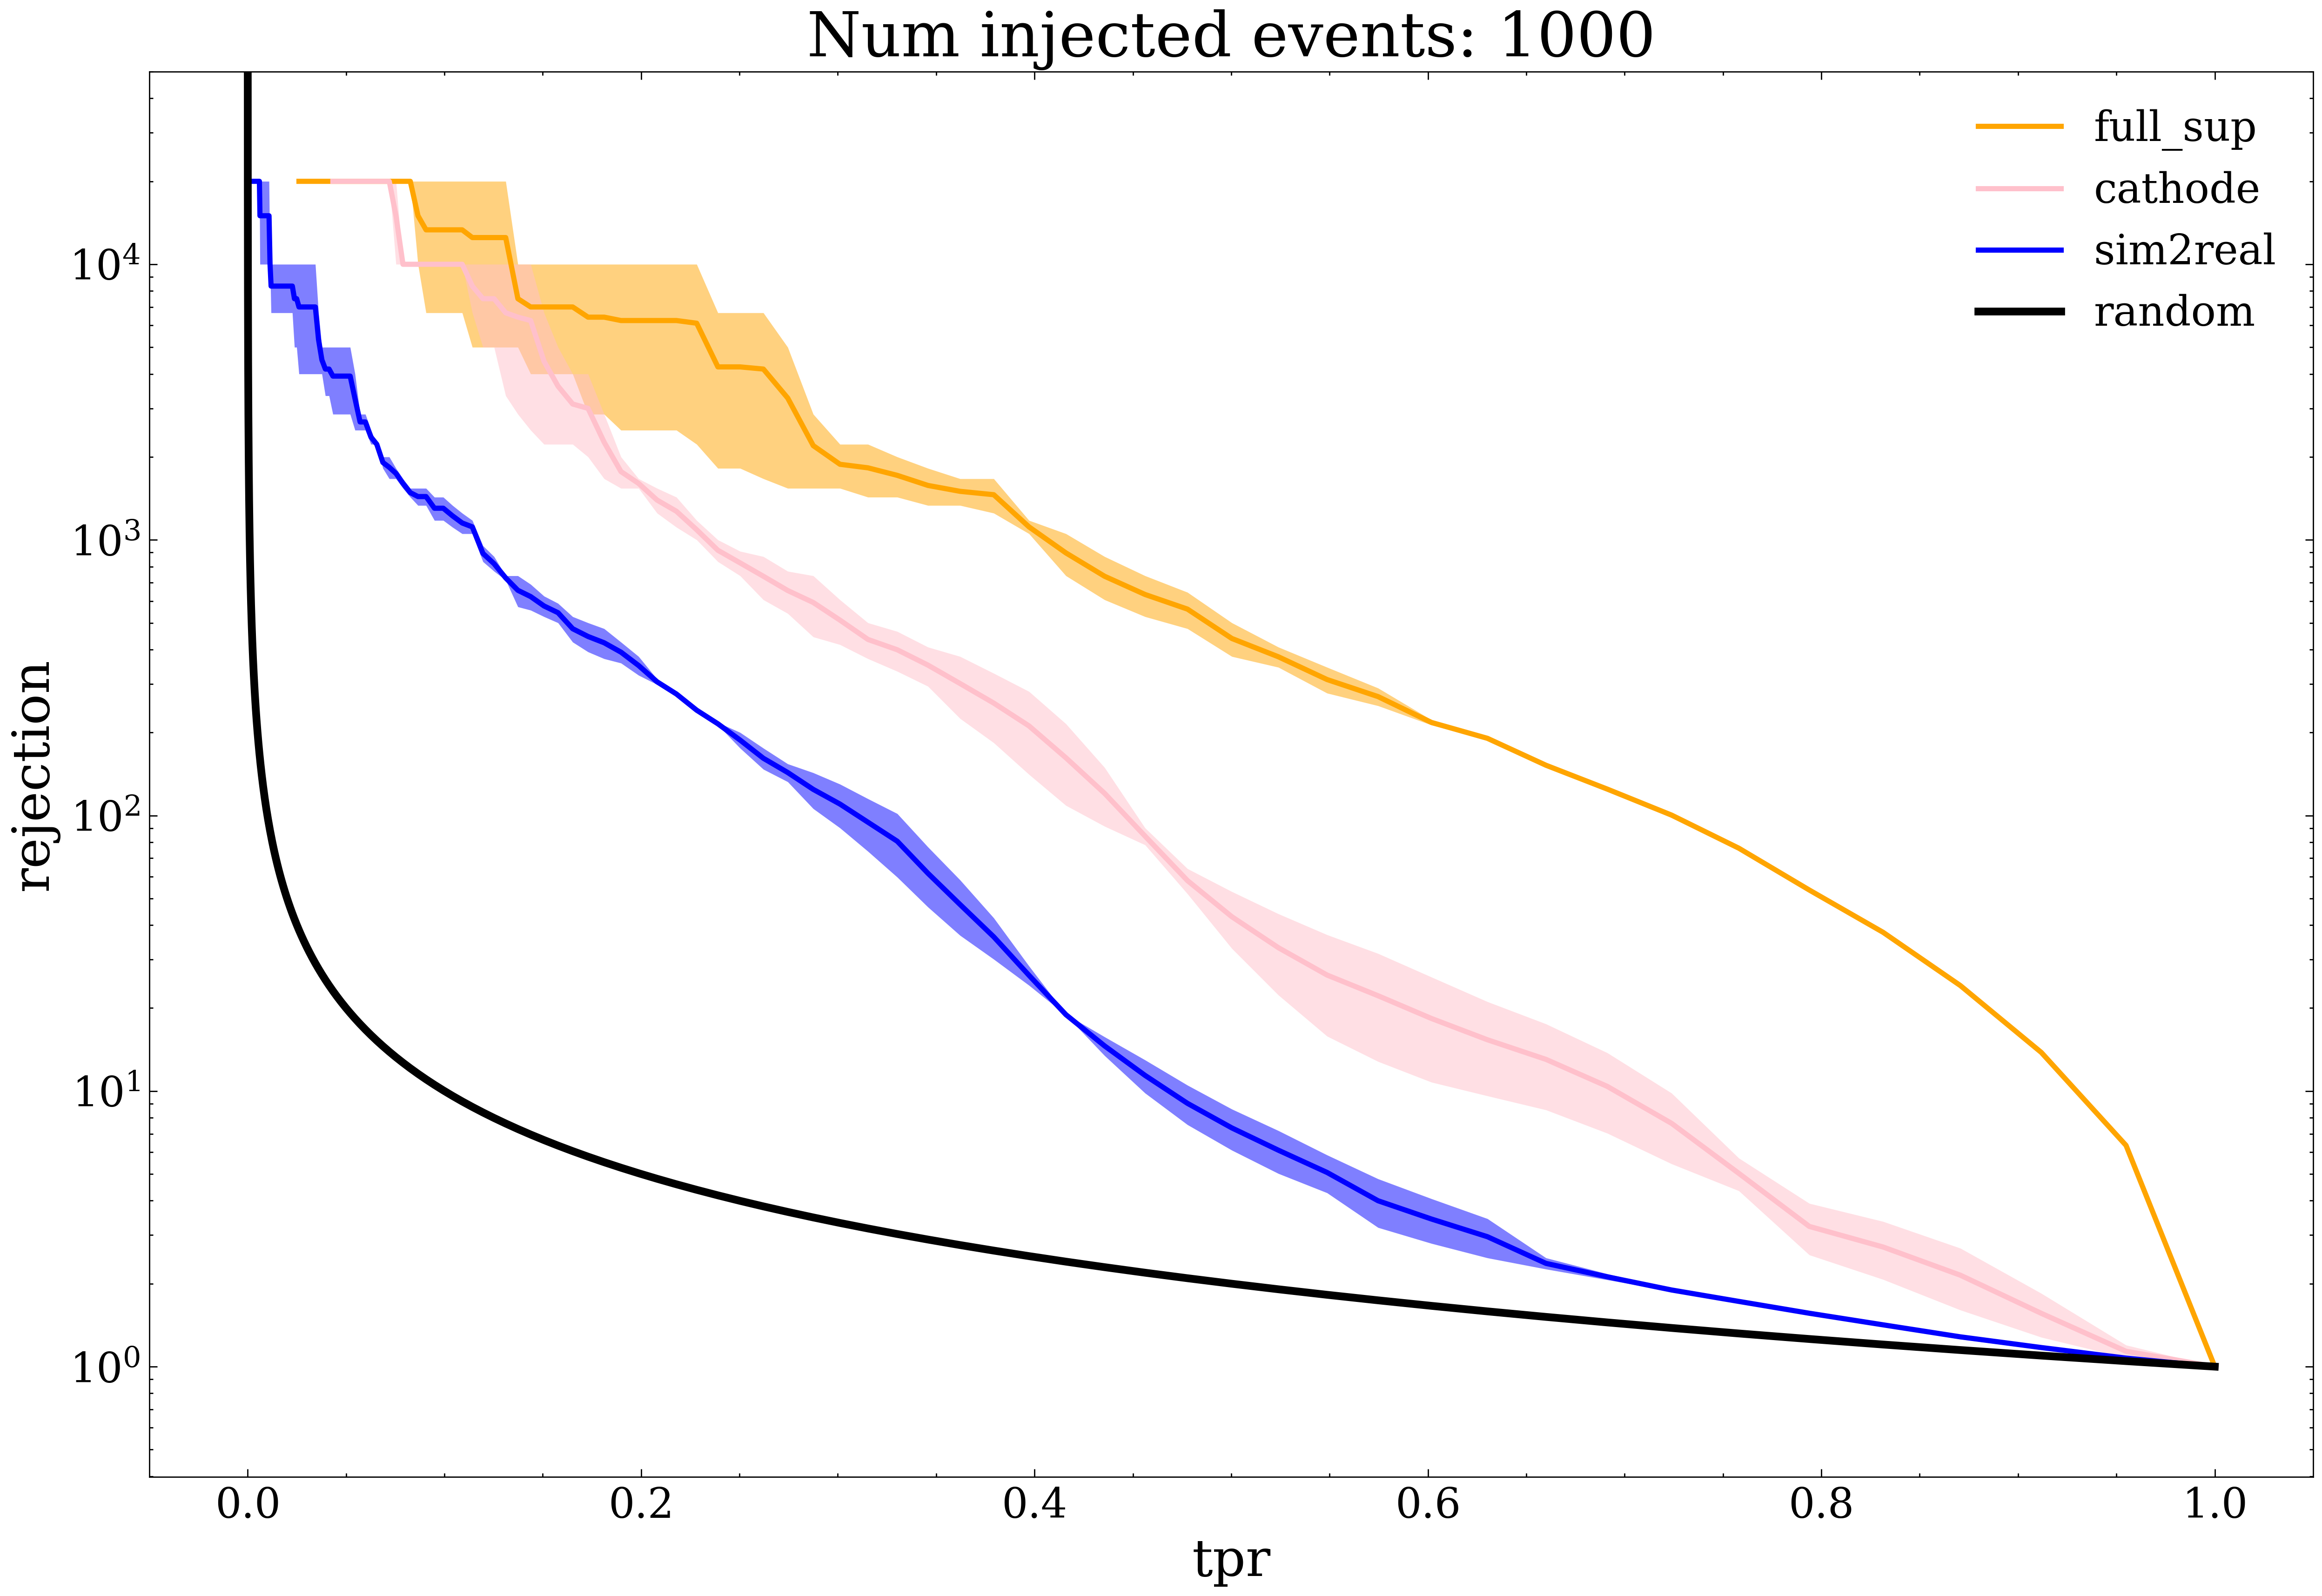

In [14]:


for n in n_sig_inj:

    plt.figure(figsize = (15, 10)) 
    for k in keys:
        plt.plot(x_axis, mean_rejections_dict[k][n][0], label = k, color = colors_dict[k], linewidth = 2)

        plt.fill_between(x_axis, mean_rejections_dict[k][n][0] - mean_rejections_dict[k][n][1],
                         mean_rejections_dict[k][n][0] + mean_rejections_dict[k][n][1],
                         alpha = 0.5, color = colors_dict[k], linewidth = 0)

    plt.plot(x_axis, 1.0/x_axis, label = "random", color = "black", linewidth = 3)

    plt.legend()
    plt.yscale("log")
    plt.xlabel("tpr")
    plt.ylabel("rejection")
    plt.title(f"Num injected events: {n}")
    plt.ylim(0, 5e4)

    plt.show()

# sic vs rej

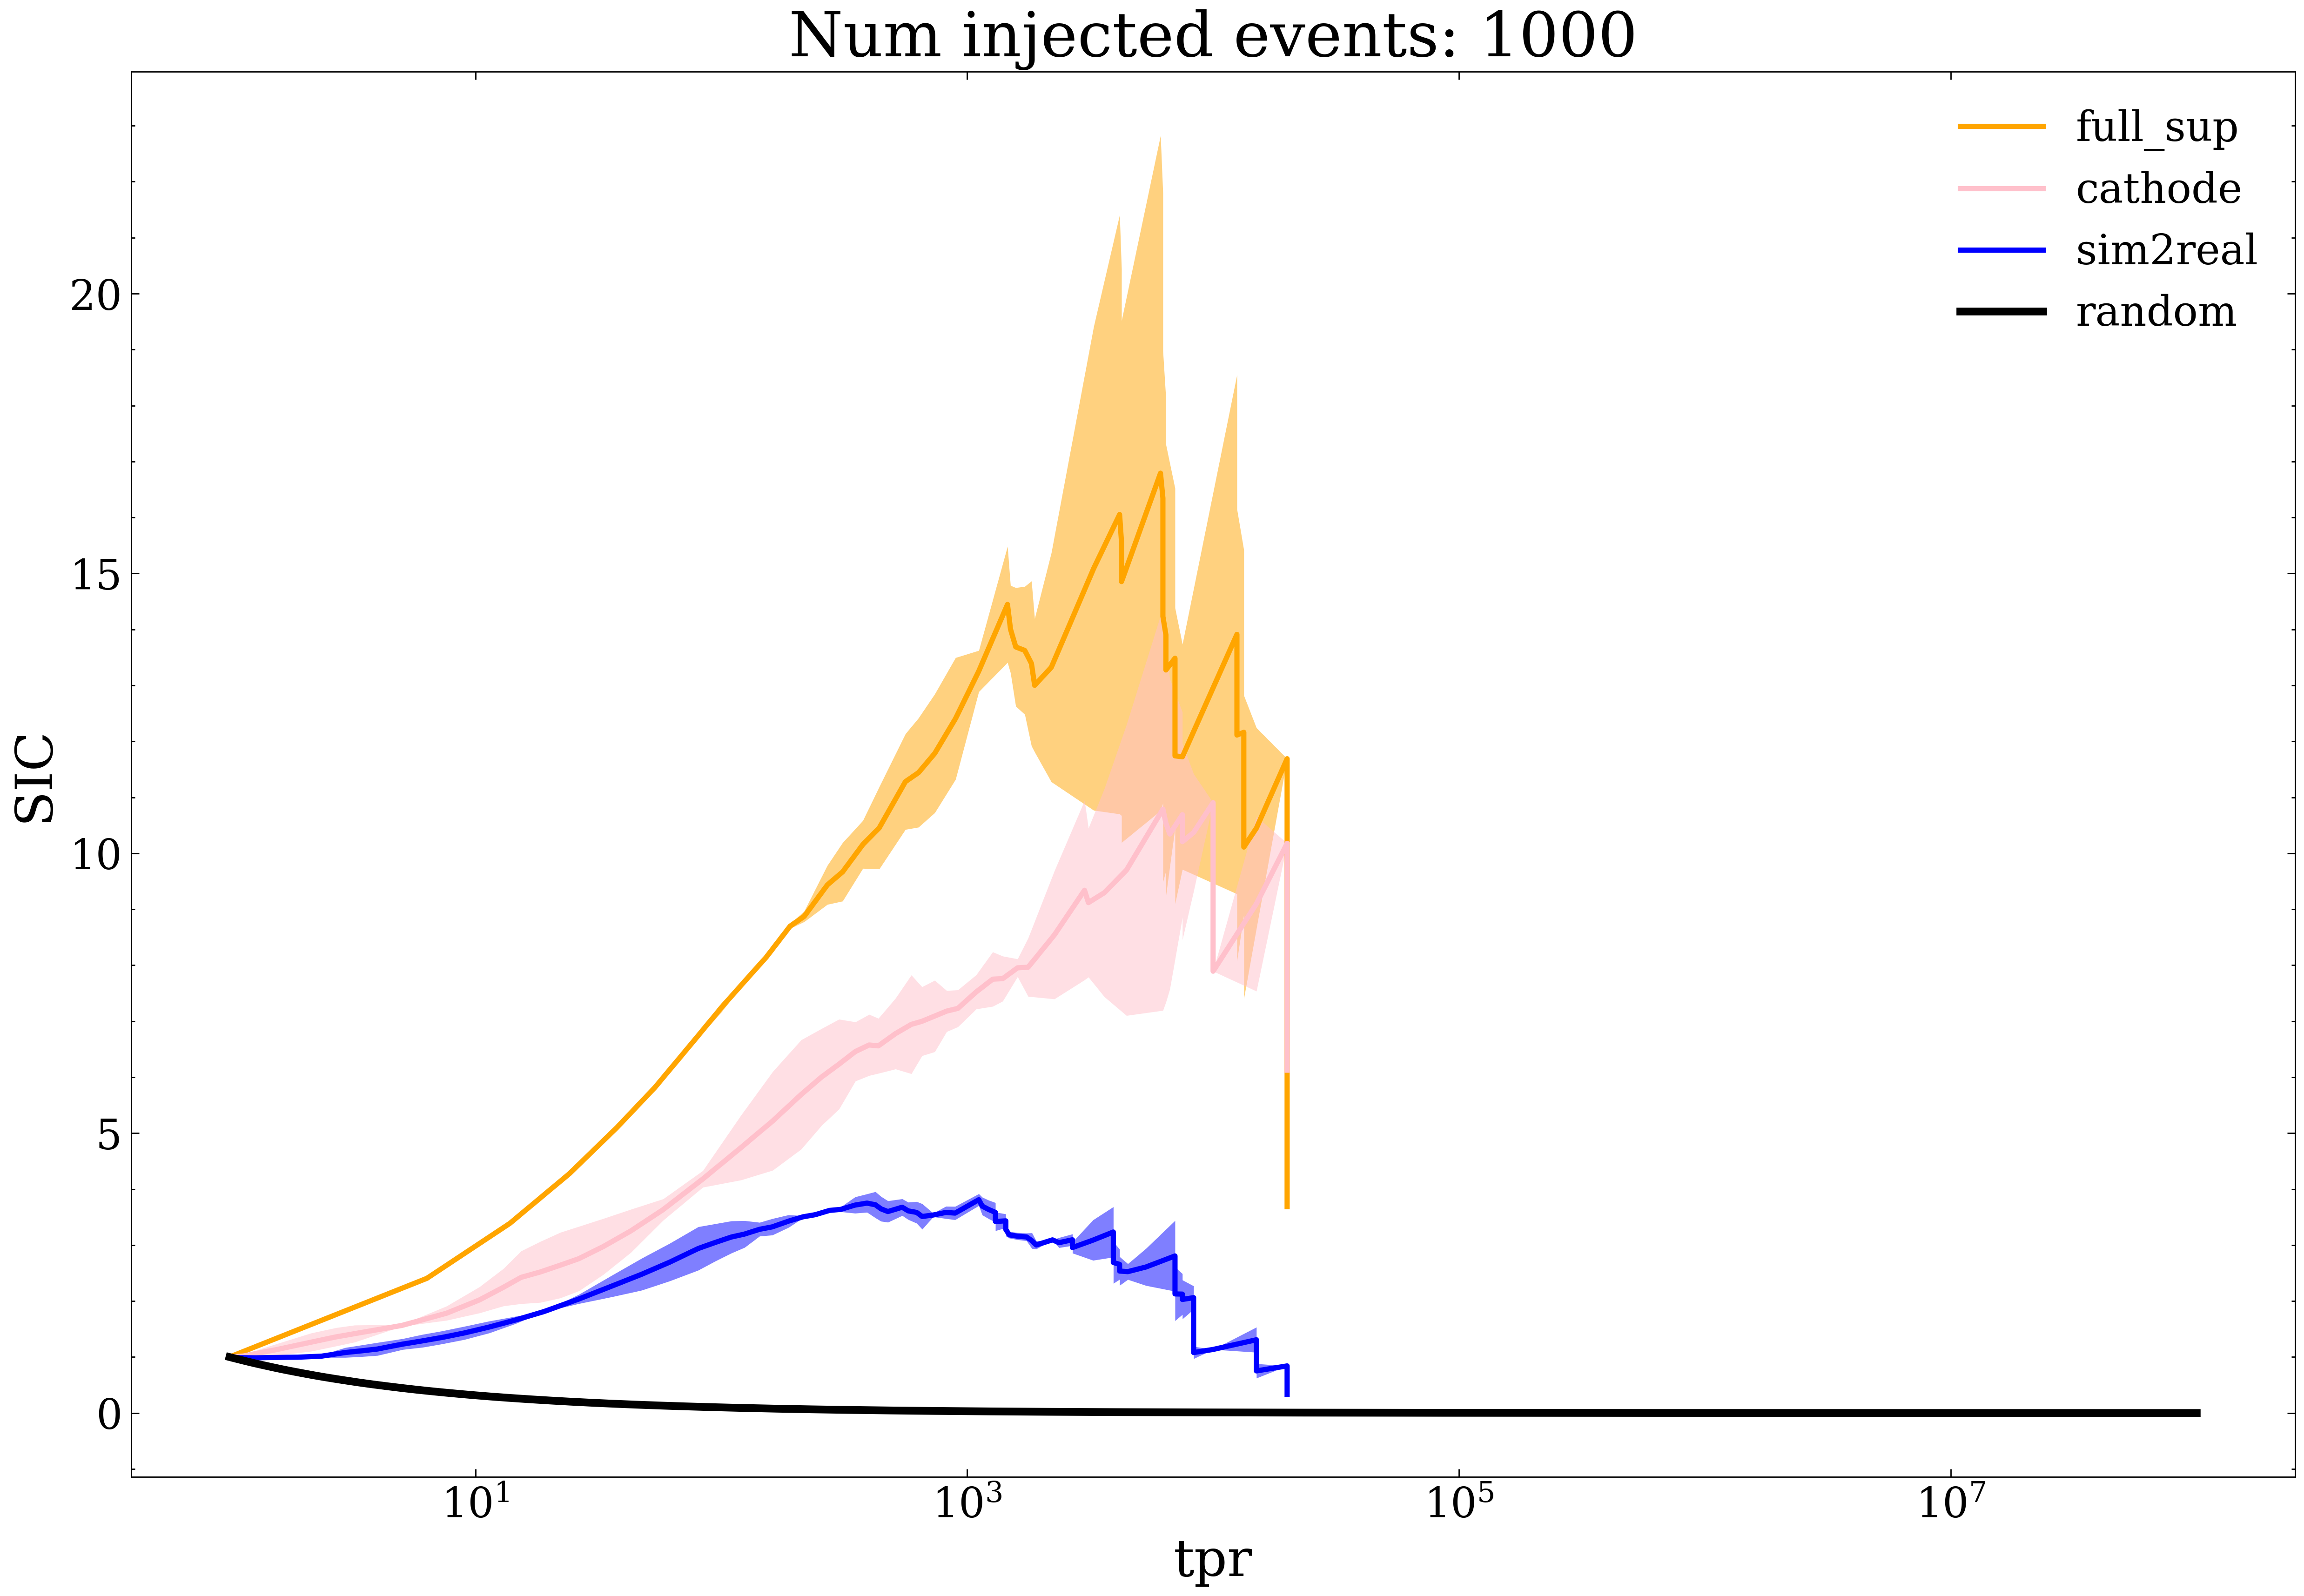

In [15]:


for n in n_sig_inj:

    plt.figure(figsize = (15, 10)) 
    for k in keys:
        plt.plot(mean_rejections_dict[k][n][0], mean_sics_dict[k][n][0], label = k, color = colors_dict[k], linewidth = 2)

        plt.fill_between(mean_rejections_dict[k][n][0], mean_sics_dict[k][n][0] - mean_sics_dict[k][n][1],
                         mean_sics_dict[k][n][0] + mean_sics_dict[k][n][1],
                         alpha = 0.5, color = colors_dict[k], linewidth = 0)

    plt.plot(1.0/x_axis, x_axis/np.sqrt(x_axis), label = "random", color = "black", linewidth = 3)

    plt.legend()
    plt.xscale("log")
    plt.xlabel("tpr")
    plt.ylabel("SIC")
    plt.title(f"Num injected events: {n}")

    plt.show()

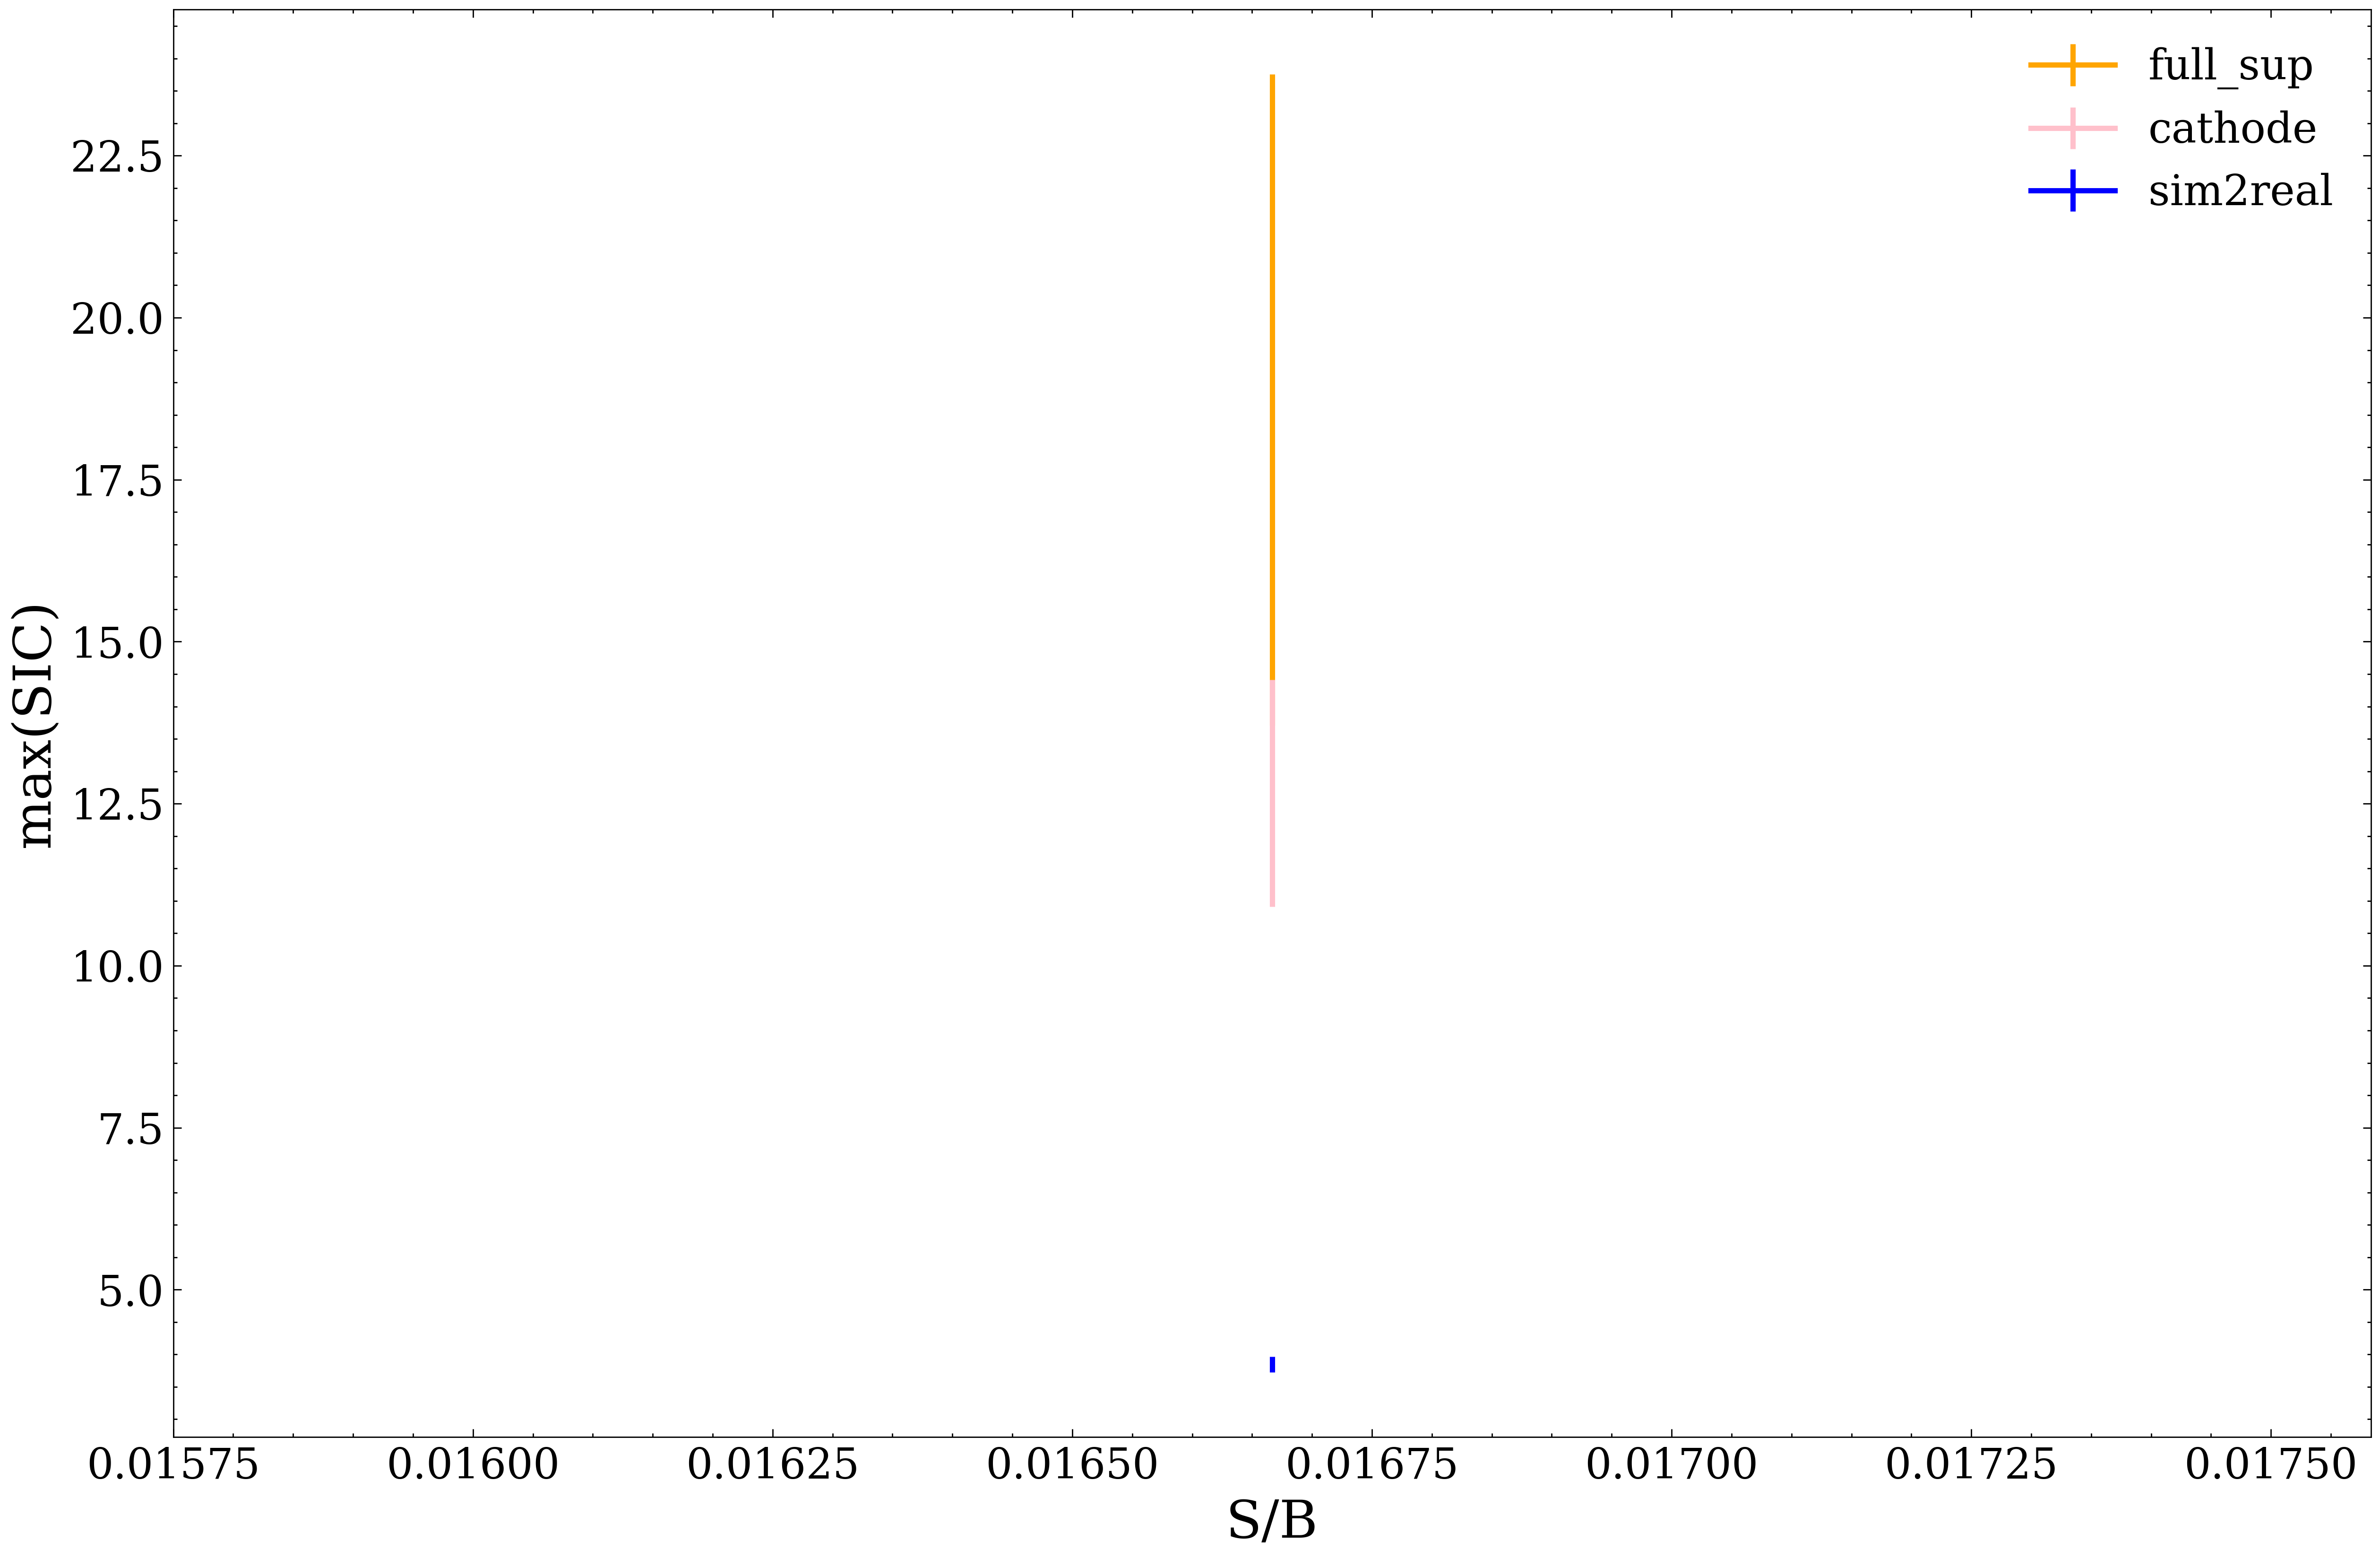

In [16]:
x_vals = [n / 60000 for n in n_sig_inj]



plt.figure(figsize = (15, 10)) 
for k in keys:
    plt.errorbar(x_vals, mean_max_sics_dict[k][0], yerr = mean_max_sics_dict[k][1], label = k, color = colors_dict[k], linewidth = 2)

   

    #plt.plot(x_axis, 1.0/x_axis, label = "random", color = "black", linewidth = 3)

plt.legend()
plt.xlabel("S/B")
plt.ylabel("max(SIC)")

plt.show()


    